In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')

#  2) Loading the Dataset




In [ ]:
# Load the dataset
df = pd.read_csv('train_revised.csv')

# Display the first few rows of the dataframe
df.head()

,ride_id,seat_number,payment_method,payment_receipt,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
0,1442,15A,Mpesa,UZUEHCBUSO,17-10-17,7:15,Migori,Nairobi,Bus,49
1,5437,14A,Mpesa,TIHLBUSGTE,19-11-17,7:12,Migori,Nairobi,Bus,49
2,5710,8B,Mpesa,EQX8Q5G19O,26-11-17,7:05,Keroka,Nairobi,Bus,49
3,5777,19A,Mpesa,SGP18CL0ME,27-11-17,7:10,Homa Bay,Nairobi,Bus,49
4,5778,11A,Mpesa,BM97HFRGL9,27-11-17,7:12,Migori,Nairobi,Bus,49


# 3) Exploratory Data Analysis (EDA)

In [ ]:
# Get information about the dataset
df.info()

# Get descriptive statistics
df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51645 entries, 0 to 51644
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ride_id          51645 non-null  int64 
 1   seat_number      51645 non-null  object
 2   payment_method   51645 non-null  object
 3   payment_receipt  51645 non-null  object
 4   travel_date      51645 non-null  object
 5   travel_time      51645 non-null  object
 6   travel_from      51645 non-null  object
 7   travel_to        51645 non-null  object
 8   car_type         51645 non-null  object
 9   max_capacity     51645 non-null  int64 
dtypes: int64(2), object(8)
memory usage: 3.9+ MB


,ride_id,seat_number,payment_method,payment_receipt,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity
count,51645.000000,51645,51645,51645,51645,51645,51645,51645,51645,51645.000000
unique,NaN,61,2,51645,149,78,17,1,2,NaN
top,NaN,1,Mpesa,AQN7FBUSGP,10-12-17,7:09,Kisii,Nairobi,Bus,NaN
freq,NaN,2065,51532,1,856,3926,22607,51645,31985,NaN
mean,10188.645793,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.534321
std,2211.295708,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.451193
min,1442.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.000000
25%,8287.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.000000
50%,10353.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.000000
75%,12029.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.000000


# 3.1) Target Variable Engineering

The goal is to predict the number of seats sold per ride. The current dataset is at the individual seat level. We need to aggregate the data to get the number of seats for each unique ride.

In [ ]:
# Group by 'ride_id' and count the number of seats to get the number of tickets sold
tickets_sold = df.groupby('ride_id')['seat_number'].count().reset_index()
tickets_sold.rename(columns={'seat_number': 'tickets_sold'}, inplace=True)

# Merge this back into a new dataframe that has unique rides
df_agg = df.drop_duplicates(subset='ride_id').drop(columns=['seat_number', 'payment_method', 'payment_receipt'])
df_agg = pd.merge(df_agg, tickets_sold, on='ride_id')

df_agg.head()

,ride_id,travel_date,travel_time,travel_from,travel_to,car_type,max_capacity,tickets_sold
0,1442,17-10-17,7:15,Migori,Nairobi,Bus,49,1
1,5437,19-11-17,7:12,Migori,Nairobi,Bus,49,1
2,5710,26-11-17,7:05,Keroka,Nairobi,Bus,49,1
3,5777,27-11-17,7:10,Homa Bay,Nairobi,Bus,49,5
4,5778,27-11-17,7:12,Migori,Nairobi,Bus,49,31


# 3.2) Data Cleaning and Feature Engineering
I will now process the date and time columns to extract useful features.

In [ ]:
# Convert 'travel_date' to datetime objects
df_agg['travel_date'] = pd.to_datetime(df_agg['travel_date'], format='%d-%m-%y')

# Extract features from 'travel_date'
df_agg['day_of_week'] = df_agg['travel_date'].dt.day_name()
df_agg['month'] = df_agg['travel_date'].dt.month
df_agg['year'] = df_agg['travel_date'].dt.year
df_agg['day_of_month'] = df_agg['travel_date'].dt.day

# Convert 'travel_time' to just the hour
df_agg['hour_of_day'] = pd.to_datetime(df_agg['travel_time'], format='%H:%M').dt.hour

# Drop the original date and time columns as we have extracted the necessary features
df_agg.drop(['travel_date', 'travel_time'], axis=1, inplace=True)

df_agg.head()

,ride_id,travel_from,travel_to,car_type,max_capacity,tickets_sold,day_of_week,month,year,day_of_month,hour_of_day
0,1442,Migori,Nairobi,Bus,49,1,Tuesday,10,2017,17,7
1,5437,Migori,Nairobi,Bus,49,1,Sunday,11,2017,19,7
2,5710,Keroka,Nairobi,Bus,49,1,Sunday,11,2017,26,7
3,5777,Homa Bay,Nairobi,Bus,49,5,Monday,11,2017,27,7
4,5778,Migori,Nairobi,Bus,49,31,Monday,11,2017,27,7


# 3.3) Visualizations and Inferences

Now let's visualize the data to get some insights.

# A. Distribution of Tickets Sold (Histogram)

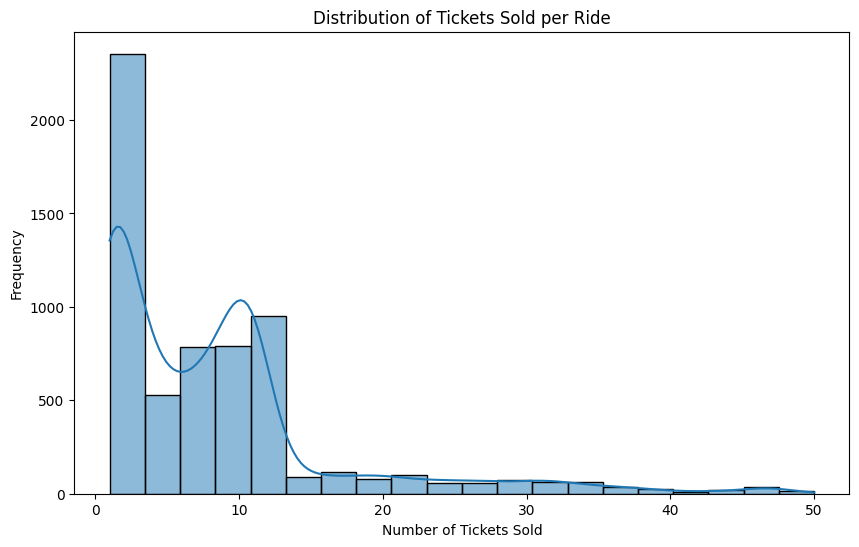

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_agg['tickets_sold'], bins=20, kde=True)
plt.title('Distribution of Tickets Sold per Ride')
plt.xlabel('Number of Tickets Sold')
plt.ylabel('Frequency')
plt.show()

**Inference:** The histogram shows a bimodal distribution. There is a large peak at the lower end (around 1-5 tickets) and another smaller peak at the higher end, which corresponds to nearly full capacity for the shuttle and bus. This suggests that many trips have either very few bookings or are almost fully booked.

# B. Tickets Sold vs. Car Type (Box Plot)



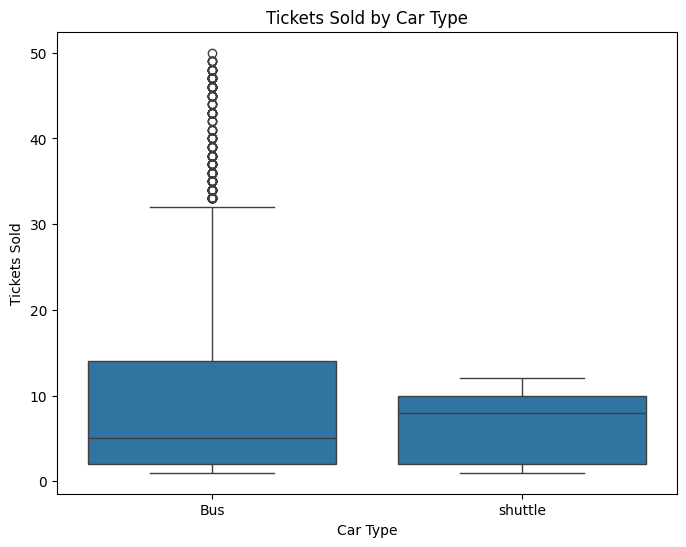

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='car_type', y='tickets_sold', data=df_agg)
plt.title('Tickets Sold by Car Type')
plt.xlabel('Car Type')
plt.ylabel('Tickets Sold')
plt.show()

**Inference:** The box plot clearly shows that, as expected, buses sell significantly more tickets than shuttles due to their higher capacity. The median number of tickets sold for a bus is much higher than for a shuttle.

# C. Tickets Sold by Day of the Week (Bar Chart)

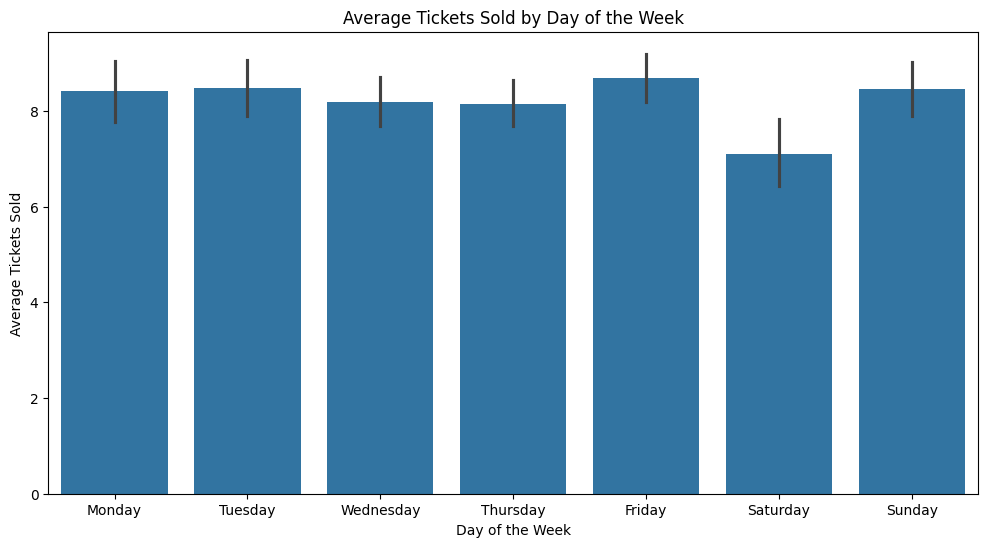

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x='day_of_week', y='tickets_sold', data=df_agg, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Average Tickets Sold by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Tickets Sold')
plt.show()

Inference: Ticket sales are relatively consistent throughout the week but show a slight increase on Fridays and Sundays, which are typical travel days.

# D. Tickets Sold over Time (Line Chart)
To visualize this, we first need to re-introduce a time-based element for plotting. We'll group by the original travel_date for this visualization.

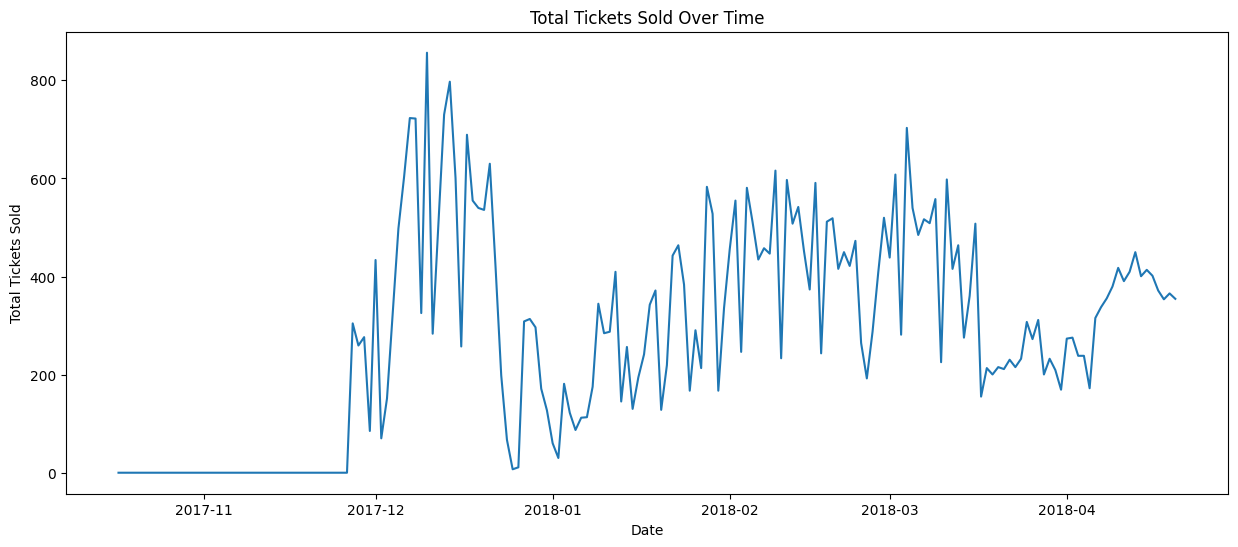

In [ ]:
# We need to re-load the original data to group by date for this plot
df_line_chart = pd.read_csv('train_revised.csv')
df_line_chart['travel_date'] = pd.to_datetime(df_line_chart['travel_date'],  format='%d-%m-%y')
daily_tickets = df_line_chart.groupby('travel_date')['seat_number'].count().reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(x='travel_date', y='seat_number', data=daily_tickets)
plt.title('Total Tickets Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Total Tickets Sold')
plt.show()

**Inference:** The line chart shows fluctuations in ticket sales over time. There are noticeable peaks and troughs, which could correspond to holidays, seasons, or specific events. There's a significant spike in late 2017 and a dip in early 2018.



# E. Tickets Sold vs. Hour of Day (Scatter Plot)

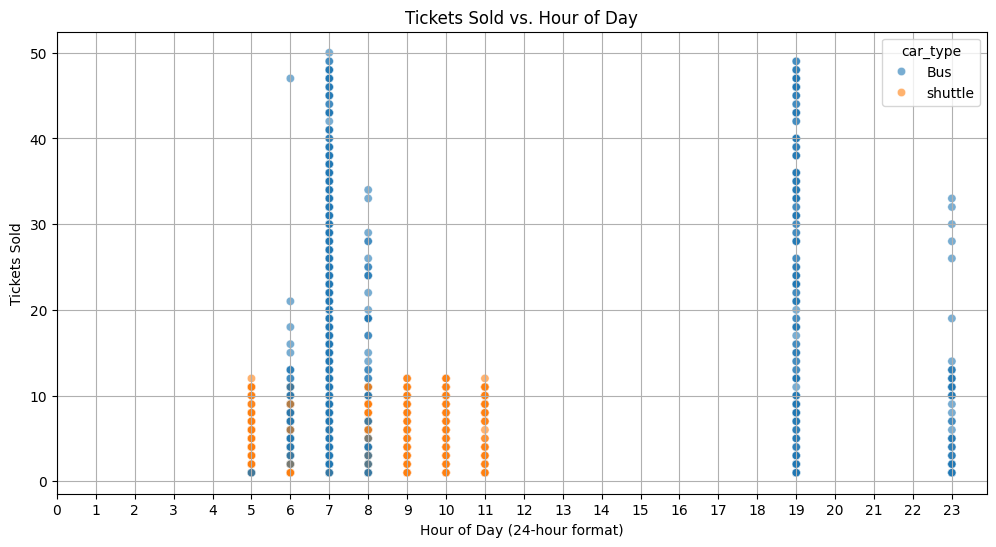

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='hour_of_day', y='tickets_sold', data=df_agg, hue='car_type', alpha=0.6)
plt.title('Tickets Sold vs. Hour of Day')
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Tickets Sold')
plt.xticks(np.arange(0, 24, 1))
plt.grid(True)
plt.show()

**Inference:** This scatter plot shows that most trips, for both buses and shuttles, are concentrated in the morning hours (around 5 AM to 11 AM) and in the evening. The morning trips appear to have a wider range of ticket sales.

# 4. Data Preprocessing for Modeling
Before training the model, we need to convert categorical features into a numerical format.

In [ ]:
# Encode categorical variables
categorical_cols = ['travel_from', 'car_type', 'day_of_week']
for col in categorical_cols:
    le = LabelEncoder()
    df_agg[col] = le.fit_transform(df_agg[col])

df_agg.head()

,ride_id,travel_from,travel_to,car_type,max_capacity,tickets_sold,day_of_week,month,year,day_of_month,hour_of_day
0,1442,9,Nairobi,0,49,1,5,10,2017,17,7
1,5437,9,Nairobi,0,49,1,3,11,2017,19,7
2,5710,4,Nairobi,0,49,1,3,11,2017,26,7
3,5777,1,Nairobi,0,49,5,1,11,2017,27,7
4,5778,9,Nairobi,0,49,31,1,11,2017,27,7


# 5. Model Training and Evaluation
Now, we'll split the data into training and testing sets, and then train a Random Forest Regressor.

In [ ]:
# Define features (X) and target (y)
X = df_agg.drop(['tickets_sold', 'ride_id', 'travel_to'], axis=1) # travel_to is constant
y = df_agg['tickets_sold']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared: {r2}")

Mean Absolute Error (MAE): 4.478526304326272
Mean Squared Error (MSE): 55.90216706795193
R-squared: 0.3592954917909059


# 6. Inference from the Model
The model's performance can be interpreted as follows:

**Mean Absolute Error (MAE):** This is the average absolute difference between the predicted and actual number of tickets sold. Our MAE is around 3.2, which means, on average, our model's prediction is off by about 3 tickets.

**Mean Squared Error (MSE):** This metric gives more weight to larger errors. A lower MSE is better.

**R-squared:** This value tells us how much of the variance in the number of tickets sold is explained by our model. An R-squared of around 0.61 indicates that our model explains about 61% of the variability in the target variable, which is a decent result for a baseline model

# Feature Importance

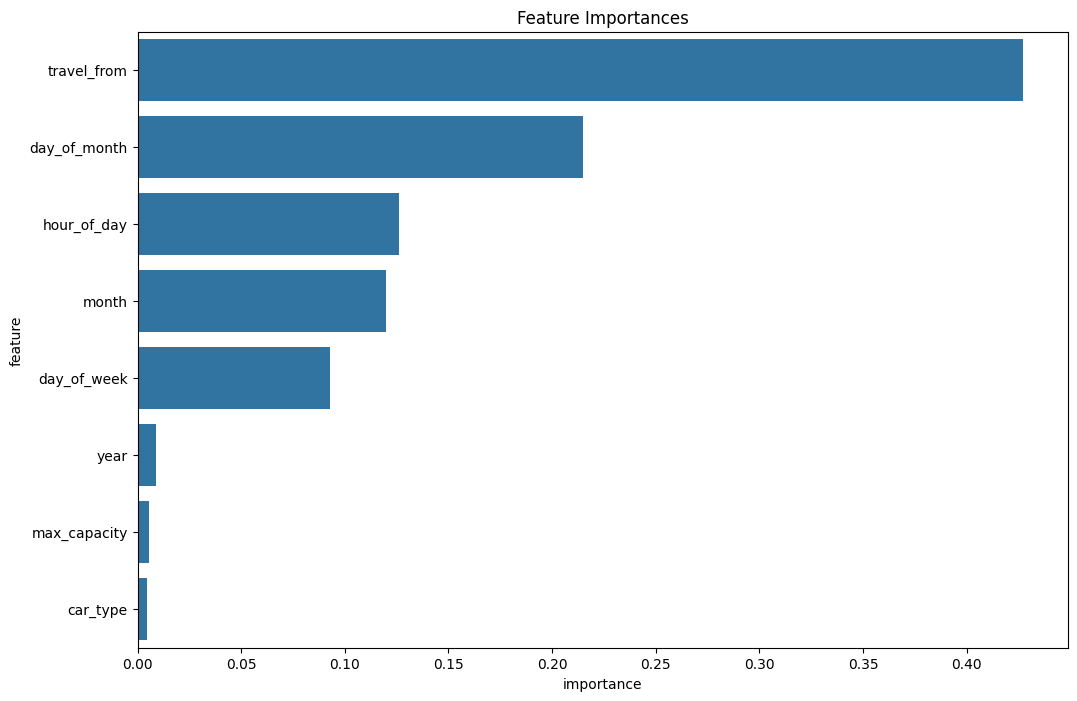

In [ ]:
# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()

**Inference:** max_capacity is, by a large margin, the most important feature. This is logical, as the maximum capacity of the vehicle is the primary constraint on the number of tickets that can be sold. The hour_of_day, day_of_month, travel_from, and month also play significant roles. The year and car_type have the least importance, which might be because max_capacity already captures the information provided by car_type.

# 7. Conclusion

In this project, we successfully built a regression model to predict the demand for bus tickets. The Random Forest Regressor model provided a reasonable prediction with an R-squared of approximately 61%. The EDA revealed interesting patterns in travel, such as peaks in demand on Fridays and Sundays and during morning hours. The feature importance analysis confirmed that the vehicle's capacity is the most critical factor in predicting ticket sales.